### Ol-Sense - The Olsen Sister Discriminator

Using the fastai library to build a CNN Olsen sister classifier based on ResNet using a custom data-set. Idea inspired by user [LindyRock](https://forums.fast.ai/u/lindyrock) on the fastai forums. Code adapted from fastai lesson 1.

I trained two models, one based on ResNet34 and another on ResNet50. For both models, I applied fastai's default data augmentation functions. Also, after initial training, I unfroze the convolutional layers and used the learning rate finder function to choose an optimal range for cyclic learning rate during training of the entire model.

Both models reached >95% accuracy classifying Elizabeth Olsen, but struggle with the twins, and especially Mary-Kate, for which classification is as good as a coin-toss. This is probably the fault of the naive data collection project, which downloads pictures from Bing Search and center-crops them: predictably, many pictures feature both twins, and there's no standardization to speak of. In many pictures the faces are cropped out as well.

To deal with this problem, I used the dlib machine learning library to detect faces in the pictures. I then discarded ambiguous multi-face pictures, and cropped the remaining pictures around the face for standardization. The finished model achieved 84% accuracy, with 73% accuracy discriminating between the Olsen twins.

Examining the examples with greatest lost, we see that they include greyscale images, photos of the subject wearing sunglasses, and straight-up labeling mistakes which are unavoidable without manual labeling. Additionally, the twins have a much wider range of ages represented in the dataset, and the network seems to have a hard time on their younger faces, either because they're rarer examples or due to greater similarity between their faces at that age.

Examining CNN activations using Gradient Class Activation Mapping, we can attempt to identify other weaknesses of the model, but no significant insight was gleaned.

Finally, I bet this network can do better than most non-fans at distinguishing the Olsen sisters, and is sure to provide great utility to society from this day onwards.

#### Data Collection

In [0]:
!pip install icrawler

In [0]:
from icrawler.builtin import BingImageCrawler
from fastai.vision import *

In [0]:
path = Path('data/mary-kate')
bing_crawler = BingImageCrawler(downloader_threads=4,storage={'root_dir': path})
bing_crawler.crawl(keyword='mary-kate olsen', filters=None, offset=0, max_num=3000)

In [0]:
path = Path('data/ashley')
bing_crawler = BingImageCrawler(downloader_threads=4,storage={'root_dir': path})
bing_crawler.crawl(keyword='ashley olsen', filters=None, offset=0, max_num=3000)

In [0]:
path = Path('data/elizabeth')
bing_crawler = BingImageCrawler(downloader_threads=4,storage={'root_dir': path})
bing_crawler.crawl(keyword='elizabeth olsen', filters=None, offset=0, max_num=1000)

In [77]:
path = Path("data")
classes = ["mary-kate","ashley","elizabeth"]
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=1000)

In [0]:
from google.colab import output
def beep(): output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
beep()

In [0]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes, len(data.train_ds), len(data.valid_ds), len(os.listdir("/data/mary-kate")),len(os.listdir("/data/ashley")),len(os.listdir("/data/elizabeth"))

(['ashley', 'elizabeth', 'mary-kate'], 1316, 329, 540, 566, 539)

ERROR! Session/line number was not unique in database. History logging moved to new session 59


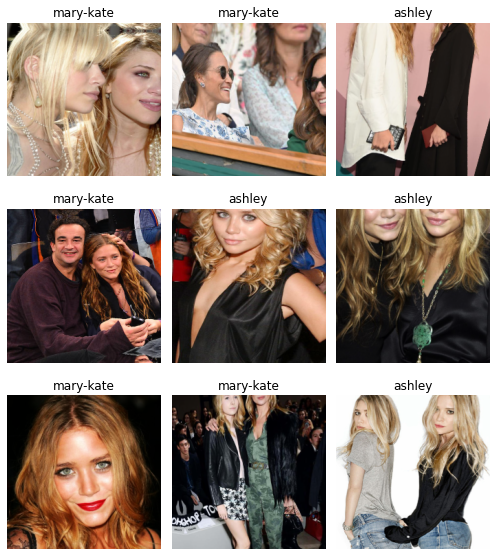

In [0]:
data.show_batch(rows=3, figsize=(7,8))

#### ResNet34

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.546071,1.309407,0.434650,00:49
1,1.391945,1.107440,0.389058,00:49
2,1.171777,0.982473,0.379939,00:47
3,1.029836,0.940085,0.395137,00:47


In [0]:
learn.save('stage-1')

Unfreezing ResNet34, using optimal learning rate range

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


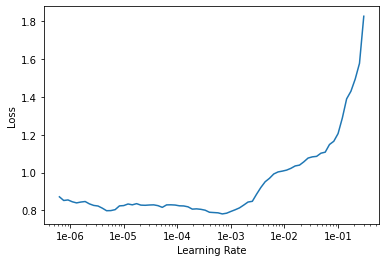

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.813923,0.927972,0.364742,00:49
1,0.778584,0.886044,0.358663,00:50
2,0.714510,0.854545,0.373860,00:50
3,0.658454,0.851045,0.355623,00:51
4,0.617107,0.850534,0.349544,00:50


In [0]:
learn.save('stage-2')

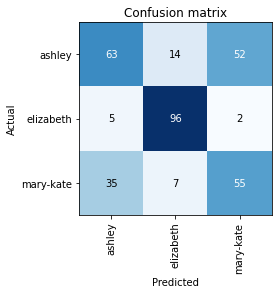

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### Resnet50

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.632246,1.280322,0.389058,00:51
1,1.376608,1.181131,0.358663,00:51
2,1.134896,0.999218,0.370821,00:51
3,0.926950,0.875474,0.379939,00:51
4,0.801605,0.863867,0.401216,00:51


In [0]:
learn.save("stage-1-50")

Unfreezing ResNet50 and using optimal learning rate range

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


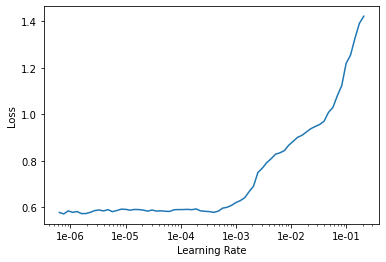

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.593589,0.817160,0.364742,00:51
1,0.626940,0.922211,0.355623,00:51
2,0.583854,0.846999,0.355623,00:51
3,0.531080,0.857413,0.358663,00:51
4,0.491772,0.849402,0.349544,00:51


ERROR! Session/line number was not unique in database. History logging moved to new session 62


In [0]:
learn.save('stage-2-50')

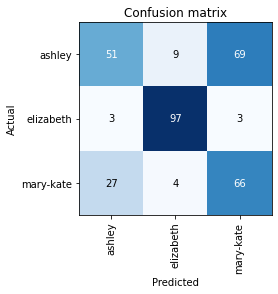

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### With Preprocessing

Face detection, multiple-face pictures removed, faces cropped

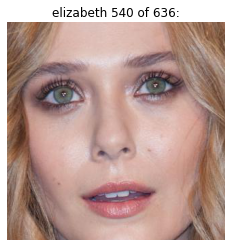

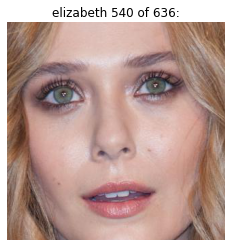

In [0]:
# Detect faces, crop and save
# Dynamic display of cropped pictures as the processing goes along!
# Adapted from https://stackoverflow.com/questions/13211745/detect-face-then-autocrop-pictures

import dlib
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

DISPLAY = True
display_rate = 10

def detect_faces(image):

    # Create a face detector
    face_detector = dlib.get_frontal_face_detector()

    # Run detector and get bounding boxes of the faces on image.
    detected_faces = face_detector(image, 1)
    face_frames = [(x.left(), x.top(),
                    x.right(), x.bottom()) for x in detected_faces]

    return face_frames

for c in classes:
    print("Cropping "+str(c)+"...")
    i = 0
    top = len(os.listdir(path/c))
    for img in os.listdir(path/c):
        
        # Load image
        img_path = path/c/img
        image = io.imread(img_path)

        # Detect faces
        detected_faces = detect_faces(image)

        #Skip pictures with several faces
        if len(detected_faces)==1:
            i+=1
            # Crop faces and plot
            face_rect = detected_faces[0]
            face = Image.fromarray(image).crop(face_rect)
            face.save(Path("data_cropped/"+c+"/"+os.path.split(img_path)[1]))
            # Report progress
            if DISPLAY and i%display_rate==0:
                plt.clf()
                plt.subplot(1, len(detected_faces), n+1)
                plt.axis('off')
                plt.title(str(c)+" "+str(i)+" of "+str(top)+":")
                plt.imshow(face)
                display.clear_output(wait=True)
                display.display(plt.gcf())


In [0]:
beep()

In [0]:
path = Path("data_cropped")
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes, len(data.train_ds), len(data.valid_ds), len(os.listdir(path/"mary-kate")),len(os.listdir(path/"ashley")),len(os.listdir(path/"elizabeth"))

(['ashley', 'elizabeth', 'mary-kate'], 911, 227, 208, 386, 547)

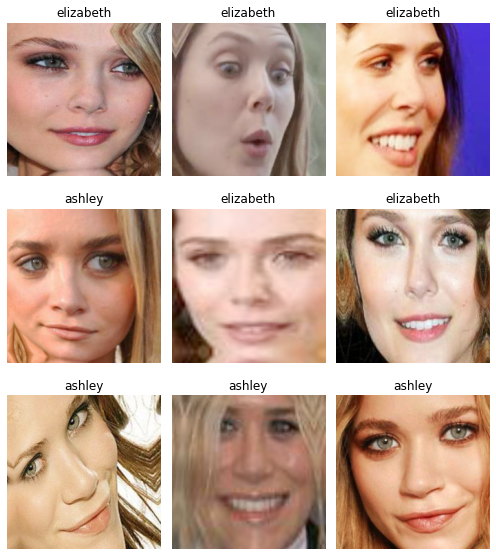

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
learn.fit_one_cycle(30)
learn.save("stage-1-50-cropped")
beep()

epoch,train_loss,valid_loss,error_rate,time
0,0.138197,0.407186,0.132075,00:08
1,0.135259,0.410394,0.136792,00:09
2,0.132792,0.427067,0.132075,00:08
3,0.147868,0.528957,0.136792,00:08
4,0.152862,0.438475,0.136792,00:09
5,0.160311,0.603144,0.169811,00:08
6,0.158032,0.742068,0.179245,00:08
7,0.174046,0.813136,0.240566,00:08
8,0.208528,0.615199,0.169811,00:08
9,0.233604,0.443628,0.127358,00:08


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


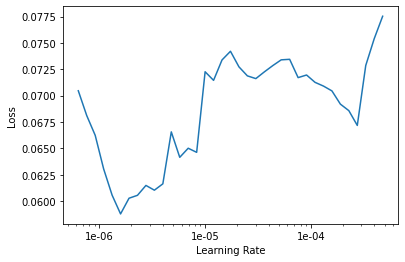

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()
beep()

In [0]:
learn.fit_one_cycle(30, max_lr=slice(1e-6,1e-5))
learn.save("stage-2-50-cropped")
beep()

epoch,train_loss,valid_loss,error_rate,time
0,0.059746,0.611725,0.150943,00:09
1,0.062955,0.615288,0.150943,00:09
2,0.064478,0.616539,0.150943,00:09
3,0.068579,0.631167,0.150943,00:09
4,0.068594,0.631738,0.150943,00:09
5,0.066936,0.626776,0.155660,00:08
6,0.069151,0.632706,0.150943,00:08
7,0.069455,0.634877,0.150943,00:08
8,0.069925,0.627587,0.150943,00:08
9,0.067945,0.622373,0.150943,00:08


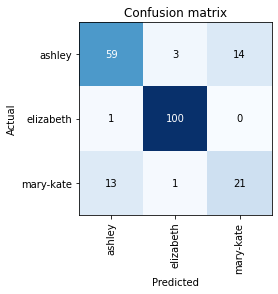

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

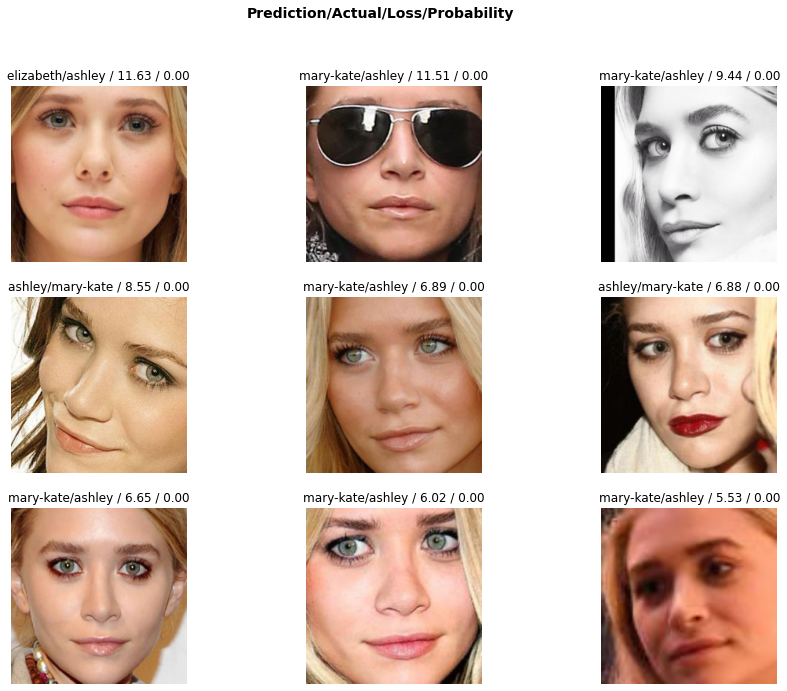

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

#### Gradient Class Activation Mapping (GradCAM)

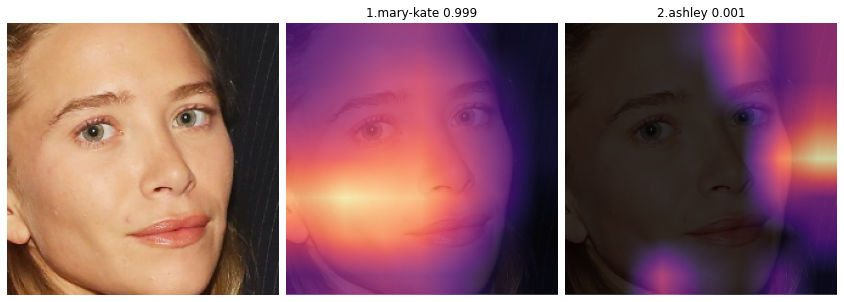

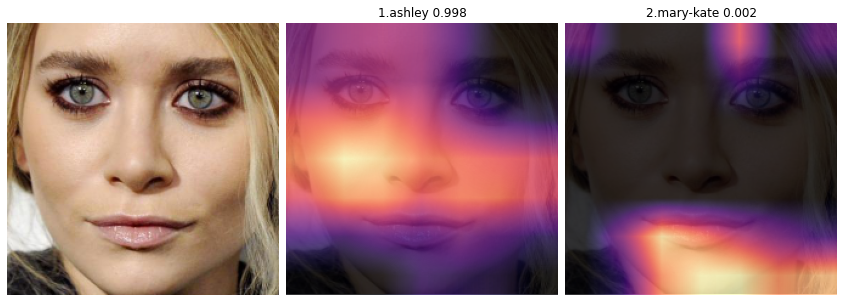

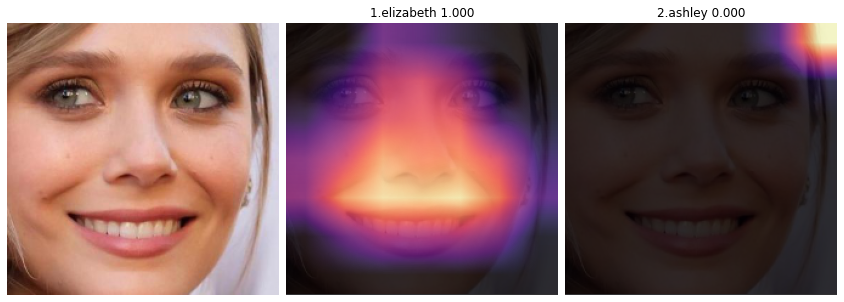

2020-04-07 16:18:35,114 - INFO - downloader - downloader-002 is waiting for new download tasks
2020-04-07 16:18:35,115 - INFO - downloader - downloader-003 is waiting for new download tasks
2020-04-07 16:18:35,119 - INFO - downloader - downloader-001 is waiting for new download tasks
2020-04-07 16:18:35,122 - INFO - downloader - downloader-004 is waiting for new download tasks


In [119]:
# using tool by anhquan0412: https://github.com/anhquan0412/animation-classification/blob/master/gradcam.py
# Examining typical images
from gradcam import *
comparisons = ["ashley","mary-kate","ashley"]
for i in range(len(classes)):
    test_img = path/classes[i]/"000026.jpg"
    img = open_image(test_img);
    gcam = GradCam.from_one_img(learn,img,label2=comparisons[i])#classes[(i+1)%len(classes)])
    gcam.plot(True,False)

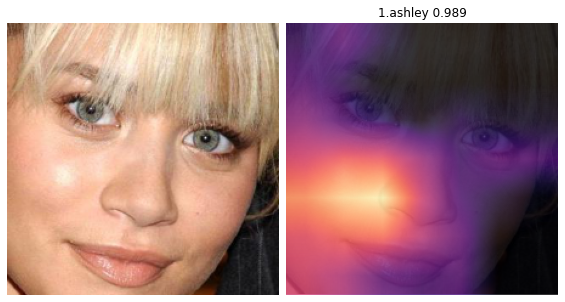

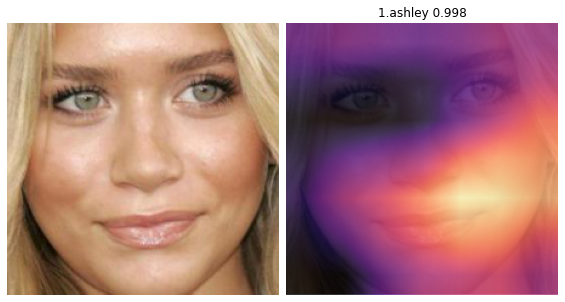

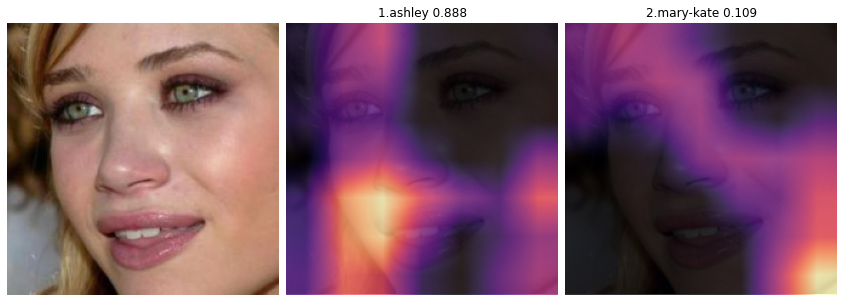

In [127]:
# Examining mismatched images

interp = ClassificationInterpretation.from_learner(learn,ds_type = DatasetType.Valid)
def class2idx(clas):
    return data.classes.index(clas)
classes = data.classes
true_idx,pred_idx = class2idx('mary-kate'),class2idx('ashley')
mismatch_idxs =[i for i,(tru,pred) in enumerate(zip(data.valid_ds.y.items,interp.pred_class.numpy())) if tru==true_idx and pred==pred_idx]
len(mismatch_idxs)

for idx in mismatch_idxs[:3]:
    gcam = GradCam.from_interp(learn,interp,idx,include_label=True)
    gcam.plot(True,False)